In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D
import os
from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [7]:
#retrieve data
num =2000 # number of profiles
nvza =2 # number of channels
nsza=1

s = 82 # output slice size
ts = 82 # input slice size 32

In [8]:
#get the averaged reflectance from the dataset 
r=np.load('monte_carlo_r.npy')
print(r.shape)
r=r.reshape((2000, 82, 2))
print(r.shape)

(2000, 82, 1, 2)
(2000, 82, 2)


In [9]:
#get the averaged reflectance from the dataset 
c=np.load('monte_carlo_cot.npy')
c.shape

(2000, 82)

In [10]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800
print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')





train_size: 1600 profiles
test_size: 400 profiles


In [11]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

NameError: name 'model' is not defined

In [12]:
checkpoint_path = "training_all_bilstm/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [14]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------
def eval_model(train_image, test_image, train_label, test_label):
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()

    bsize = 16
    eps = 2000

    input_layer = tf.keras.layers.Input(shape=(ts,2),name='Input')
    bi=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True,input_shape=(ts,2)))(input_layer) 
    bi=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(bi) 
    flat=tf.keras.layers.Flatten()(bi)
    output = tf.keras.layers.Dense(82,activation='relu')(flat)


    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()


    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    
     # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,save_freq=5*bsize)
    # Save the weights using the `checkpoint_path` format
    model.save_weights(checkpoint_path.format(epoch=0))

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [17]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds) #800

X_train=np.zeros((5,400*4,ts,2))
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,ts,2))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 400  401  402 ... 1997 1998 1999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [18]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 2)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 82, 256)           134144    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 82, 256)           394240    
_________________________________________________________________
flatten (Flatten)            (None, 20992)             0         
_________________________________________________________________
dense (Dense)                (None, 82)                1721426   
Total params: 2,249,810
Trainable params: 2,249,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
75/75 [==============================] - 10s 51ms/step - loss: 140.5420 - mean_squared_error: 140.5420 -

75/75 [==============================] - 2s 31ms/step - loss: 3.4071 - mean_squared_error: 3.4071 - root_mean_squared_error: 1.8457 - val_loss: 4.4106 - val_mean_squared_error: 4.4106 - val_root_mean_squared_error: 2.1001
Epoch 19/2000
 9/75 [==>...........................] - ETA: 1s - loss: 3.0491 - mean_squared_error: 3.0491 - root_mean_squared_error: 1.7461
Epoch 00019: saving model to training_all_bilstm\cp-0019.ckpt
75/75 [==============================] - 2s 31ms/step - loss: 3.0325 - mean_squared_error: 3.0325 - root_mean_squared_error: 1.7414 - val_loss: 4.2306 - val_mean_squared_error: 4.2306 - val_root_mean_squared_error: 2.0568
Epoch 20/2000
14/75 [====>.........................] - ETA: 1s - loss: 2.9005 - mean_squared_error: 2.9005 - root_mean_squared_error: 1.7031
Epoch 00020: saving model to training_all_bilstm\cp-0020.ckpt
75/75 [==============================] - 2s 29ms/step - loss: 2.8475 - mean_squared_error: 2.8475 - root_mean_squared_error: 1.6874 - val_loss: 4.2730

24/75 [========>.....................] - ETA: 1s - loss: 0.9290 - mean_squared_error: 0.9290 - root_mean_squared_error: 0.9638
Epoch 00038: saving model to training_all_bilstm\cp-0038.ckpt
75/75 [==============================] - 2s 28ms/step - loss: 0.9553 - mean_squared_error: 0.9553 - root_mean_squared_error: 0.9773 - val_loss: 2.4850 - val_mean_squared_error: 2.4850 - val_root_mean_squared_error: 1.5764
Epoch 39/2000
29/75 [==========>...................] - ETA: 1s - loss: 0.9213 - mean_squared_error: 0.9213 - root_mean_squared_error: 0.9598
Epoch 00039: saving model to training_all_bilstm\cp-0039.ckpt
75/75 [==============================] - 2s 29ms/step - loss: 0.9263 - mean_squared_error: 0.9263 - root_mean_squared_error: 0.9624 - val_loss: 2.3661 - val_mean_squared_error: 2.3661 - val_root_mean_squared_error: 1.5382
Epoch 40/2000
33/75 [============>.................] - ETA: 0s - loss: 0.8530 - mean_squared_error: 0.8530 - root_mean_squared_error: 0.9234
Epoch 00040: saving mod

75/75 [==============================] - 2s 30ms/step - loss: 0.3799 - mean_squared_error: 0.3799 - root_mean_squared_error: 0.6163 - val_loss: 2.4499 - val_mean_squared_error: 2.4499 - val_root_mean_squared_error: 1.5652
Epoch 58/2000
45/75 [=================>............] - ETA: 0s - loss: 0.3281 - mean_squared_error: 0.3281 - root_mean_squared_error: 0.5727
Epoch 00058: saving model to training_all_bilstm\cp-0058.ckpt
75/75 [==============================] - 2s 31ms/step - loss: 0.3360 - mean_squared_error: 0.3360 - root_mean_squared_error: 0.5795 - val_loss: 2.4457 - val_mean_squared_error: 2.4457 - val_root_mean_squared_error: 1.5639
Epoch 59/2000
49/75 [==================>...........] - ETA: 0s - loss: 0.3359 - mean_squared_error: 0.3359 - root_mean_squared_error: 0.5795
Epoch 00059: saving model to training_all_bilstm\cp-0059.ckpt
75/75 [==============================] - 2s 31ms/step - loss: 0.3401 - mean_squared_error: 0.3401 - root_mean_squared_error: 0.5831 - val_loss: 2.4497

75/75 [==============================] - 2s 28ms/step - loss: 31.0936 - mean_squared_error: 31.0936 - root_mean_squared_error: 5.5736 - val_loss: 25.6473 - val_mean_squared_error: 25.6473 - val_root_mean_squared_error: 5.0643
Epoch 3/2000
10/75 [===>..........................] - ETA: 1s - loss: 24.6999 - mean_squared_error: 24.6999 - root_mean_squared_error: 4.9697
Epoch 00003: saving model to training_all_bilstm\cp-0003.ckpt
75/75 [==============================] - 2s 29ms/step - loss: 22.9392 - mean_squared_error: 22.9392 - root_mean_squared_error: 4.7884 - val_loss: 18.3340 - val_mean_squared_error: 18.3340 - val_root_mean_squared_error: 4.2818
Epoch 4/2000
15/75 [=====>........................] - ETA: 1s - loss: 17.2662 - mean_squared_error: 17.2662 - root_mean_squared_error: 4.1552
Epoch 00004: saving model to training_all_bilstm\cp-0004.ckpt
75/75 [==============================] - 2s 29ms/step - loss: 16.8729 - mean_squared_error: 16.8729 - root_mean_squared_error: 4.1075 - val_

23/75 [========>.....................] - ETA: 1s - loss: 2.3211 - mean_squared_error: 2.3211 - root_mean_squared_error: 1.5234
Epoch 00022: saving model to training_all_bilstm\cp-0022.ckpt
75/75 [==============================] - 2s 29ms/step - loss: 2.3876 - mean_squared_error: 2.3876 - root_mean_squared_error: 1.5450 - val_loss: 3.6794 - val_mean_squared_error: 3.6794 - val_root_mean_squared_error: 1.9182
Epoch 23/2000
30/75 [===========>..................] - ETA: 1s - loss: 2.5034 - mean_squared_error: 2.5034 - root_mean_squared_error: 1.5808
Epoch 00023: saving model to training_all_bilstm\cp-0023.ckpt
75/75 [==============================] - 2s 31ms/step - loss: 2.8521 - mean_squared_error: 2.8521 - root_mean_squared_error: 1.6861 - val_loss: 3.8526 - val_mean_squared_error: 3.8526 - val_root_mean_squared_error: 1.9628
Epoch 24/2000
35/75 [=============>................] - ETA: 1s - loss: 2.7374 - mean_squared_error: 2.7374 - root_mean_squared_error: 1.6531
Epoch 00024: saving mod

75/75 [==============================] - 2s 28ms/step - loss: 0.8466 - mean_squared_error: 0.8466 - root_mean_squared_error: 0.9201 - val_loss: 2.4067 - val_mean_squared_error: 2.4067 - val_root_mean_squared_error: 1.5513
Epoch 42/2000
44/75 [================>.............] - ETA: 0s - loss: 0.7814 - mean_squared_error: 0.7814 - root_mean_squared_error: 0.8839
Epoch 00042: saving model to training_all_bilstm\cp-0042.ckpt
75/75 [==============================] - 2s 28ms/step - loss: 0.7981 - mean_squared_error: 0.7981 - root_mean_squared_error: 0.8933 - val_loss: 2.4270 - val_mean_squared_error: 2.4270 - val_root_mean_squared_error: 1.5579
Epoch 43/2000
48/75 [==================>...........] - ETA: 0s - loss: 0.7450 - mean_squared_error: 0.7450 - root_mean_squared_error: 0.8630
Epoch 00043: saving model to training_all_bilstm\cp-0043.ckpt
75/75 [==============================] - 2s 28ms/step - loss: 0.7644 - mean_squared_error: 0.7644 - root_mean_squared_error: 0.8741 - val_loss: 2.3585

Epoch 61/2000
59/75 [======================>.......] - ETA: 0s - loss: 0.3217 - mean_squared_error: 0.3217 - root_mean_squared_error: 0.5671
Epoch 00061: saving model to training_all_bilstm\cp-0061.ckpt
75/75 [==============================] - 2s 28ms/step - loss: 0.3253 - mean_squared_error: 0.3253 - root_mean_squared_error: 0.5703 - val_loss: 2.4221 - val_mean_squared_error: 2.4221 - val_root_mean_squared_error: 1.5563
Epoch 62/2000
64/75 [========================>.....] - ETA: 0s - loss: 0.2840 - mean_squared_error: 0.2840 - root_mean_squared_error: 0.5328
Epoch 00062: saving model to training_all_bilstm\cp-0062.ckpt
75/75 [==============================] - 2s 28ms/step - loss: 0.2872 - mean_squared_error: 0.2872 - root_mean_squared_error: 0.5358 - val_loss: 2.4215 - val_mean_squared_error: 2.4215 - val_root_mean_squared_error: 1.5561
Epoch 63/2000
70/75 [===========================>..] - ETA: 0s - loss: 0.2829 - mean_squared_error: 0.2829 - root_mean_squared_error: 0.5318
Epoch 000

Epoch 7/2000
30/75 [===========>..................] - ETA: 1s - loss: 9.7837 - mean_squared_error: 9.7837 - root_mean_squared_error: 3.1278
Epoch 00007: saving model to training_all_bilstm\cp-0007.ckpt
75/75 [==============================] - 2s 31ms/step - loss: 9.5814 - mean_squared_error: 9.5814 - root_mean_squared_error: 3.0952 - val_loss: 9.3911 - val_mean_squared_error: 9.3911 - val_root_mean_squared_error: 3.0645
Epoch 8/2000
35/75 [=============>................] - ETA: 0s - loss: 8.1045 - mean_squared_error: 8.1045 - root_mean_squared_error: 2.8468
Epoch 00008: saving model to training_all_bilstm\cp-0008.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 8.1004 - mean_squared_error: 8.1004 - root_mean_squared_error: 2.8461 - val_loss: 8.3139 - val_mean_squared_error: 8.3139 - val_root_mean_squared_error: 2.8834
Epoch 9/2000
38/75 [==============>...............] - ETA: 0s - loss: 7.4440 - mean_squared_error: 7.4440 - root_mean_squared_error: 2.7281
Epoch 00009:

75/75 [==============================] - 2s 31ms/step - loss: 1.9069 - mean_squared_error: 1.9069 - root_mean_squared_error: 1.3809 - val_loss: 2.9357 - val_mean_squared_error: 2.9357 - val_root_mean_squared_error: 1.7134
Epoch 27/2000
49/75 [==================>...........] - ETA: 0s - loss: 1.6529 - mean_squared_error: 1.6529 - root_mean_squared_error: 1.2856
Epoch 00027: saving model to training_all_bilstm\cp-0027.ckpt
75/75 [==============================] - 2s 29ms/step - loss: 1.6835 - mean_squared_error: 1.6835 - root_mean_squared_error: 1.2973 - val_loss: 2.8838 - val_mean_squared_error: 2.8838 - val_root_mean_squared_error: 1.6982
Epoch 28/2000
55/75 [=====================>........] - ETA: 0s - loss: 1.6049 - mean_squared_error: 1.6049 - root_mean_squared_error: 1.2668
Epoch 00028: saving model to training_all_bilstm\cp-0028.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 1.6290 - mean_squared_error: 1.6290 - root_mean_squared_error: 1.2762 - val_loss: 2.8200

63/75 [========================>.....] - ETA: 0s - loss: 0.6773 - mean_squared_error: 0.6773 - root_mean_squared_error: 0.8228
Epoch 00046: saving model to training_all_bilstm\cp-0046.ckpt
75/75 [==============================] - 2s 28ms/step - loss: 0.6838 - mean_squared_error: 0.6838 - root_mean_squared_error: 0.8268 - val_loss: 2.3028 - val_mean_squared_error: 2.3028 - val_root_mean_squared_error: 1.5175
Epoch 47/2000
68/75 [==========================>...] - ETA: 0s - loss: 0.6441 - mean_squared_error: 0.6441 - root_mean_squared_error: 0.8024
Epoch 00047: saving model to training_all_bilstm\cp-0047.ckpt
75/75 [==============================] - 2s 29ms/step - loss: 0.6478 - mean_squared_error: 0.6478 - root_mean_squared_error: 0.8047 - val_loss: 2.3028 - val_mean_squared_error: 2.3028 - val_root_mean_squared_error: 1.5175
Epoch 48/2000
75/75 [==============================] - ETA: 0s - loss: 0.6201 - mean_squared_error: 0.6201 - root_mean_squared_error: 0.7874
Epoch 00048: saving mod

 3/75 [>.............................] - ETA: 2s - loss: 0.2501 - mean_squared_error: 0.2501 - root_mean_squared_error: 0.5000
Epoch 00066: saving model to training_all_bilstm\cp-0066.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 0.2572 - mean_squared_error: 0.2572 - root_mean_squared_error: 0.5071 - val_loss: 2.3882 - val_mean_squared_error: 2.3882 - val_root_mean_squared_error: 1.5454
Epoch 67/2000
 9/75 [==>...........................] - ETA: 1s - loss: 0.2491 - mean_squared_error: 0.2491 - root_mean_squared_error: 0.4991
Epoch 00067: saving model to training_all_bilstm\cp-0067.ckpt
75/75 [==============================] - 2s 31ms/step - loss: 0.2572 - mean_squared_error: 0.2572 - root_mean_squared_error: 0.5071 - val_loss: 2.4270 - val_mean_squared_error: 2.4270 - val_root_mean_squared_error: 1.5579
Epoch 68/2000
13/75 [====>.........................] - ETA: 1s - loss: 0.2201 - mean_squared_error: 0.2201 - root_mean_squared_error: 0.4691
Epoch 00068: saving mod

75/75 [==============================] - 2s 32ms/step - loss: 5.5889 - mean_squared_error: 5.5889 - root_mean_squared_error: 2.3640 - val_loss: 7.0951 - val_mean_squared_error: 7.0951 - val_root_mean_squared_error: 2.6637
Epoch 13/2000
60/75 [=======================>......] - ETA: 0s - loss: 5.5799 - mean_squared_error: 5.5799 - root_mean_squared_error: 2.3620 ETA: 1s - loss: 5.6896 - mean_squared_error: 5.6896 - roo
Epoch 00013: saving model to training_all_bilstm\cp-0013.ckpt
75/75 [==============================] - 2s 31ms/step - loss: 5.5471 - mean_squared_error: 5.5471 - root_mean_squared_error: 2.3550 - val_loss: 5.9209 - val_mean_squared_error: 5.9209 - val_root_mean_squared_error: 2.4333
Epoch 14/2000
64/75 [========================>.....] - ETA: 0s - loss: 4.7529 - mean_squared_error: 4.7529 - root_mean_squared_error: 2.1800
Epoch 00014: saving model to training_all_bilstm\cp-0014.ckpt
75/75 [==============================] - 2s 28ms/step - loss: 4.7592 - mean_squared_error: 4

75/75 [==============================] - ETA: 0s - loss: 1.4349 - mean_squared_error: 1.4349 - root_mean_squared_error: 1.1978
Epoch 00032: saving model to training_all_bilstm\cp-0032.ckpt
75/75 [==============================] - 2s 31ms/step - loss: 1.4353 - mean_squared_error: 1.4353 - root_mean_squared_error: 1.1980 - val_loss: 2.5866 - val_mean_squared_error: 2.5866 - val_root_mean_squared_error: 1.6083
Epoch 33/2000
75/75 [==============================] - 2s 28ms/step - loss: 1.3187 - mean_squared_error: 1.3187 - root_mean_squared_error: 1.1481 - val_loss: 2.5081 - val_mean_squared_error: 2.5081 - val_root_mean_squared_error: 1.5837
Epoch 34/2000
 4/75 [>.............................] - ETA: 1s - loss: 1.2376 - mean_squared_error: 1.2376 - root_mean_squared_error: 1.1119
Epoch 00034: saving model to training_all_bilstm\cp-0034.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 1.2842 - mean_squared_error: 1.2842 - root_mean_squared_error: 1.1331 - val_loss: 2.4774

14/75 [====>.........................] - ETA: 1s - loss: 0.5506 - mean_squared_error: 0.5506 - root_mean_squared_error: 0.7418
Epoch 00052: saving model to training_all_bilstm\cp-0052.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 0.5727 - mean_squared_error: 0.5727 - root_mean_squared_error: 0.7567 - val_loss: 2.2924 - val_mean_squared_error: 2.2924 - val_root_mean_squared_error: 1.5141
Epoch 53/2000
20/75 [=======>......................] - ETA: 1s - loss: 0.5537 - mean_squared_error: 0.5537 - root_mean_squared_error: 0.7440
Epoch 00053: saving model to training_all_bilstm\cp-0053.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 0.5574 - mean_squared_error: 0.5574 - root_mean_squared_error: 0.7466 - val_loss: 2.3255 - val_mean_squared_error: 2.3255 - val_root_mean_squared_error: 1.5250
Epoch 54/2000
24/75 [========>.....................] - ETA: 1s - loss: 0.5154 - mean_squared_error: 0.5154 - root_mean_squared_error: 0.7179
Epoch 00054: saving mod

75/75 [==============================] - 2s 30ms/step - loss: 0.2167 - mean_squared_error: 0.2167 - root_mean_squared_error: 0.4654 - val_loss: 2.4540 - val_mean_squared_error: 2.4540 - val_root_mean_squared_error: 1.5665
Epoch 72/2000
35/75 [=============>................] - ETA: 1s - loss: 0.2216 - mean_squared_error: 0.2216 - root_mean_squared_error: 0.4707
Epoch 00072: saving model to training_all_bilstm\cp-0072.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 0.2224 - mean_squared_error: 0.2224 - root_mean_squared_error: 0.4716 - val_loss: 2.5406 - val_mean_squared_error: 2.5406 - val_root_mean_squared_error: 1.5939
Epoch 73/2000
40/75 [===============>..............] - ETA: 0s - loss: 0.2793 - mean_squared_error: 0.2793 - root_mean_squared_error: 0.5279
Epoch 00073: saving model to training_all_bilstm\cp-0073.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 0.2942 - mean_squared_error: 0.2942 - root_mean_squared_error: 0.5419 - val_loss: 2.5498

Epoch 14/2000
64/75 [========================>.....] - ETA: 0s - loss: 4.8775 - mean_squared_error: 4.8775 - root_mean_squared_error: 2.2084
Epoch 00014: saving model to training_all_bilstm\cp-0014.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 4.8622 - mean_squared_error: 4.8622 - root_mean_squared_error: 2.2049 - val_loss: 5.2674 - val_mean_squared_error: 5.2674 - val_root_mean_squared_error: 2.2951
Epoch 15/2000
70/75 [===========================>..] - ETA: 0s - loss: 4.2171 - mean_squared_error: 4.2171 - root_mean_squared_error: 2.0535
Epoch 00015: saving model to training_all_bilstm\cp-0015.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 4.2183 - mean_squared_error: 4.2183 - root_mean_squared_error: 2.0538 - val_loss: 4.8819 - val_mean_squared_error: 4.8819 - val_root_mean_squared_error: 2.2095
Epoch 16/2000
74/75 [============================>.] - ETA: 0s - loss: 3.8189 - mean_squared_error: 3.8189 - root_mean_squared_error: 1.9541
Epoch 000

 3/75 [>.............................] - ETA: 1s - loss: 1.2878 - mean_squared_error: 1.2878 - root_mean_squared_error: 1.1342
Epoch 00034: saving model to training_all_bilstm\cp-0034.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 1.2403 - mean_squared_error: 1.2403 - root_mean_squared_error: 1.1136 - val_loss: 2.6263 - val_mean_squared_error: 2.6263 - val_root_mean_squared_error: 1.6206
Epoch 35/2000
10/75 [===>..........................] - ETA: 1s - loss: 1.1563 - mean_squared_error: 1.1563 - root_mean_squared_error: 1.0748
Epoch 00035: saving model to training_all_bilstm\cp-0035.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 1.1603 - mean_squared_error: 1.1603 - root_mean_squared_error: 1.0770 - val_loss: 2.5799 - val_mean_squared_error: 2.5799 - val_root_mean_squared_error: 1.6062
Epoch 36/2000
15/75 [=====>........................] - ETA: 1s - loss: 1.1119 - mean_squared_error: 1.1119 - root_mean_squared_error: 1.0542
Epoch 00036: saving mod

75/75 [==============================] - 2s 29ms/step - loss: 0.4538 - mean_squared_error: 0.4538 - root_mean_squared_error: 0.6736 - val_loss: 2.4810 - val_mean_squared_error: 2.4810 - val_root_mean_squared_error: 1.5751
Epoch 54/2000
25/75 [=========>....................] - ETA: 1s - loss: 0.4136 - mean_squared_error: 0.4136 - root_mean_squared_error: 0.6431
Epoch 00054: saving model to training_all_bilstm\cp-0054.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 0.4224 - mean_squared_error: 0.4224 - root_mean_squared_error: 0.6499 - val_loss: 2.5381 - val_mean_squared_error: 2.5381 - val_root_mean_squared_error: 1.5931
Epoch 55/2000
29/75 [==========>...................] - ETA: 1s - loss: 0.4223 - mean_squared_error: 0.4223 - root_mean_squared_error: 0.6497
Epoch 00055: saving model to training_all_bilstm\cp-0055.ckpt
75/75 [==============================] - 2s 30ms/step - loss: 0.4243 - mean_squared_error: 0.4243 - root_mean_squared_error: 0.6513 - val_loss: 2.5204

In [19]:
#quantitative result
print(' Test MSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print(' Test RMSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

 Test MSE 2.3290 with standard devisation (0.1255)
 Test RMSE 1.5256 with standard devisation (0.0404)


In [20]:
predictions.shape

(400, 82)

In [21]:
cv_scores #MSE

[2.238284111022949,
 2.2790145874023438,
 2.3151252269744873,
 2.239189386367798,
 2.5735528469085693]

In [22]:
cv_scores2 #RMSE

[1.4960895776748657,
 1.5096404552459717,
 1.5215535163879395,
 1.4963921308517456,
 1.6042298078536987]

The optimal number of epochs is 45


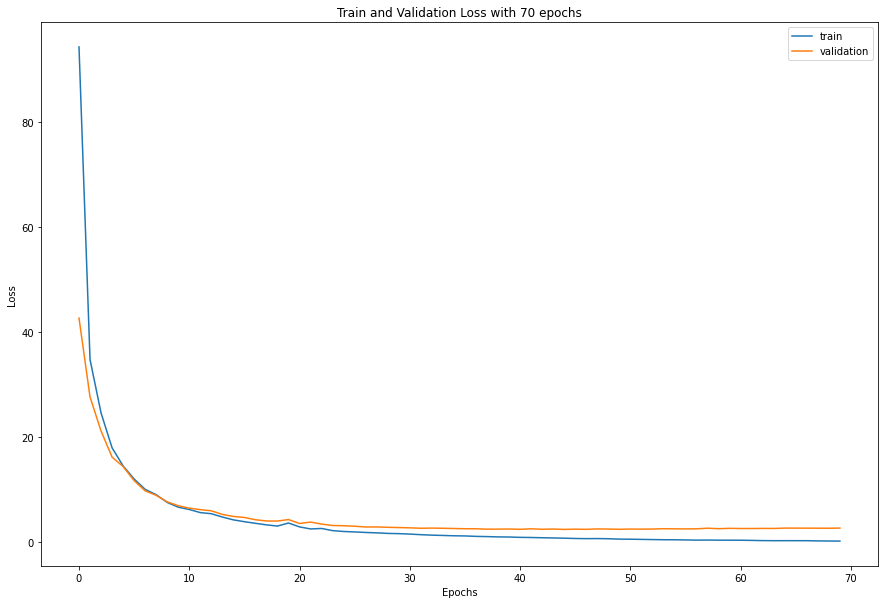

In [24]:
patience=25
# plot training and validation history
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [25]:
predict1=np.zeros((82)) #82
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

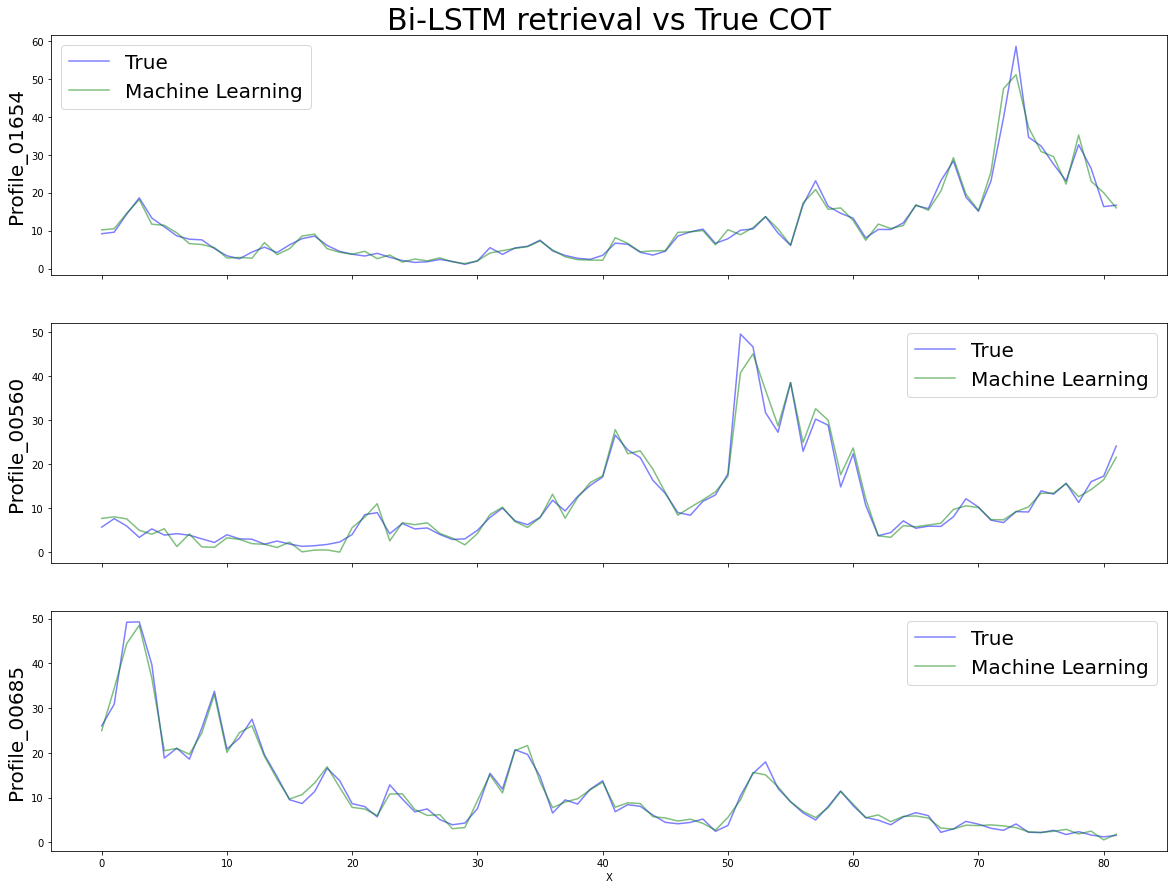

In [31]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/Bi-LSTM "+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM retrieval vs True COT",fontsize=30)
ax.plot(range(82),c[num-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=20)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning"],fontsize=20)
ax.set_ylabel(r"Profile_00560",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning"],fontsize=20)
ax.set_ylabel(r"Profile_00685",fontsize=20)  
ax.set_xlabel('X')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

# Plotting across predicted 82 COT values

In [32]:
std=[]
mean=[]

for k in range(82):
    tmp=[]
    for j in range(test_size):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))

    std.append(np.std(tmp))
    mean.append(np.mean(tmp))
std=np.array(std)
mean=np.array(mean)
std1 = np.std(mean) #standard deviation of the mean absolute difference across the 82 cot values 


In [33]:
len(mean)

82

In [34]:
len(std)

82

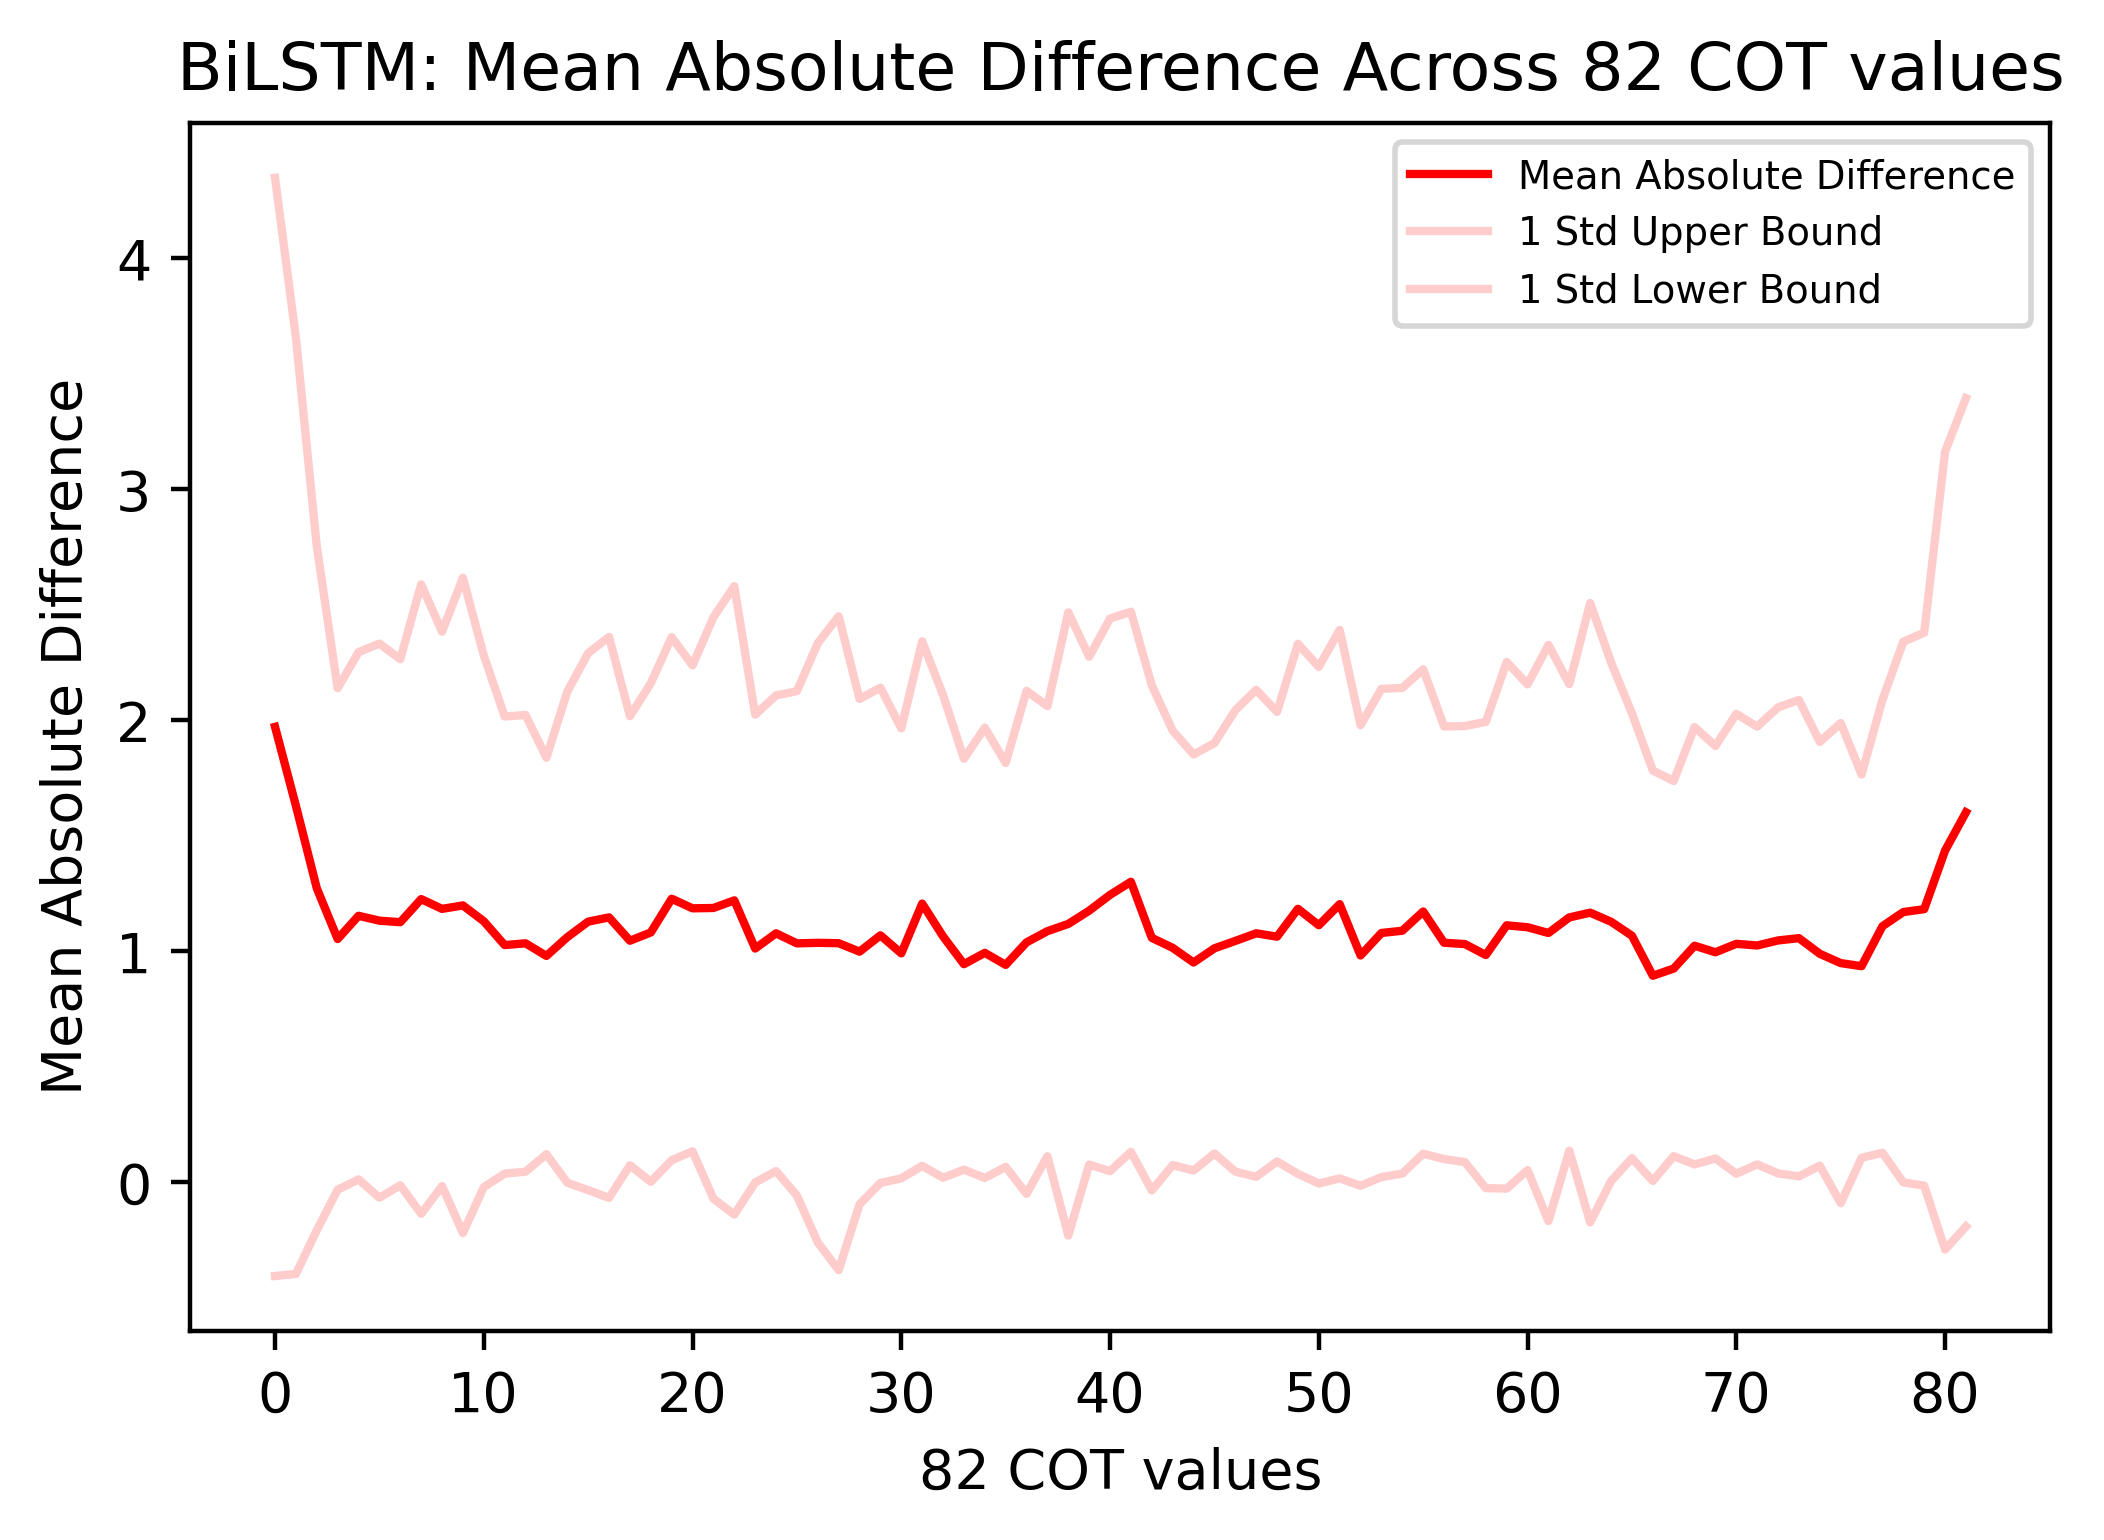

In [35]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/v1-BiLSTM_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

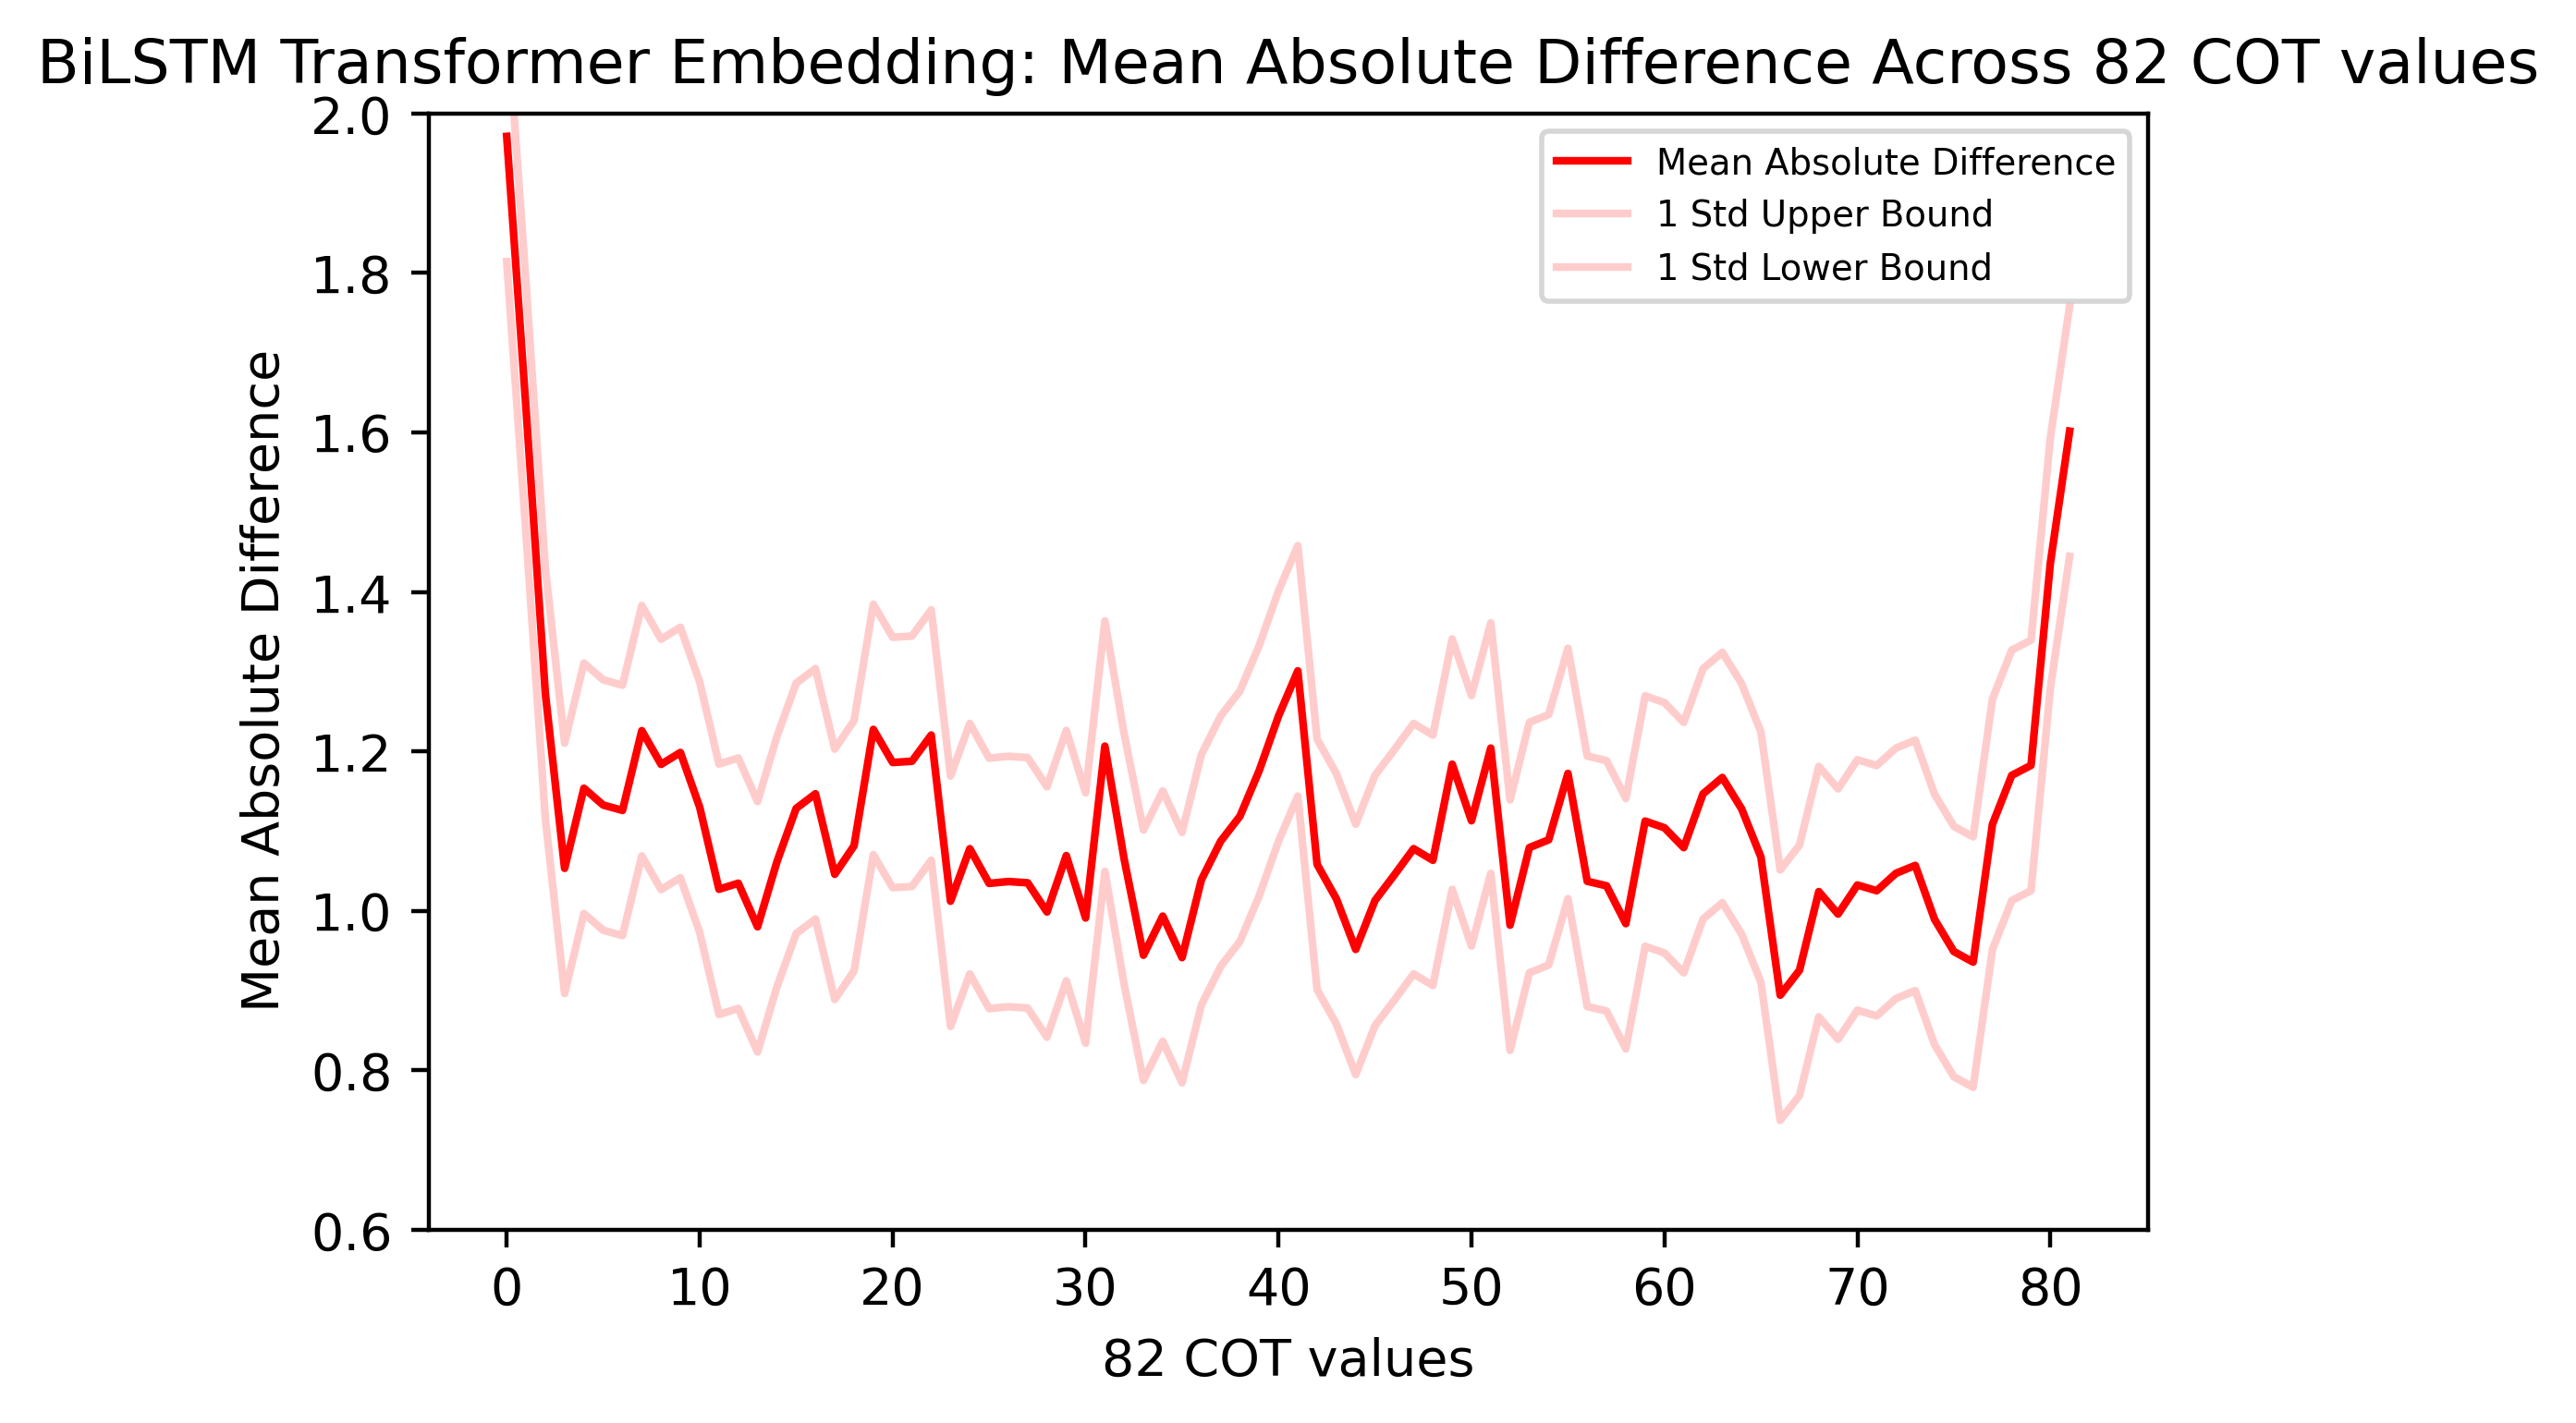

In [38]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((0.6,2))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_ Transformer_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)